In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from functions import norm, norm_inv, box_cox
#from tqdm import tqdm
import math
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import quantile_transform

from scipy import stats

/tmpscratch/cmcgrad2/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
labels = ["Higgs $p_T$", "Higgs $\eta$", "Higgs $\phi$",
             "Top $p_T$", "Top $\eta$", "Top $\phi$",
            "Anti-Top $p_T$", "Anti-Top $\eta$", "Anti-Top $\phi$"]

s_name  = []
s_value = []

In [3]:
df = pd.read_feather('/scratch365/cmcgrad2/data/pt_eta_phi/dataframes/ctq8*SM.feather').rename(columns={'ctq8*SM':'r_c'})
df = df[(df['Higgs eta'] >= -2.5) & (df['Higgs eta'] <= 2.5) &
        (df['Top eta'] >= -2.5) & (df['Top eta'] <= 2.5) &
        (df['Anti-Top eta'] >= -2.5) & (df['Anti-Top eta'] <= 2.5)]
df

,Higgs pt,Higgs eta,Higgs phi,Top pt,Top eta,Top phi,Anti-Top pt,Anti-Top eta,Anti-Top phi,r_c
0,24.3125,2.257812,0.910156,335.0,0.389648,-0.124268,496.0,-0.992188,-2.937500,1.190000e-09
1,550.0000,0.835938,-0.505859,247.5,0.900391,-2.937500,218.0,1.757812,1.886719,6.144322e-08
4,51.7500,1.812500,-2.203125,193.5,0.539062,1.109375,236.5,1.242188,-1.468750,-8.156095e-10
5,441.0000,-0.964844,2.882812,149.5,-0.391602,2.867188,580.0,-1.339844,-0.349609,1.847110e-09
6,83.2500,-1.378906,1.097656,109.0,-1.175781,-0.087158,163.5,0.738281,-2.726562,6.117232e-10
...,...,...,...,...,...,...,...,...,...,...
15931395,352.0000,-1.804688,-1.890625,361.0,-1.851562,-2.593750,964.0,-0.896484,1.113281,3.465554e-09
15931396,734.0000,-0.089355,-2.015625,584.0,-1.902344,0.996094,148.5,1.515625,1.304688,-4.829622e-10
15931398,39.8750,2.226562,2.812500,131.5,1.121094,-0.390625,85.0,1.992188,3.062500,2.096707e-03
15931399,123.5000,1.132812,0.869141,129.5,-1.640625,-1.429688,260.0,1.246094,2.687500,-6.380114e-10


In [4]:
pp = PdfPages('plots/ctq8*SM_transformations.pdf')

In [5]:
def plot(df, name, filename):
    stat = df.agg(['skew', 'kurtosis']).transpose()
    k = stats.normaltest(df['r_c'].to_numpy())[0]

    s_name.append(name)
    s_value.append(k)

    plt.rcParams['figure.figsize'] = [15, 8]

    n, bins, patches = plt.hist(df['r_c'], 100, density=False, alpha=0.75)

    xlim = np.min(bins)
    ylim = np.max(n)

    plt.text(xlim, ylim*0.03,
             'Data Statistics' + '\n' + 
             'Skew: ' + str(stat['skew']['r_c'].round(decimals=2)) + '\n' + 
             'Excess Kurtosis: '+ str((stat['kurtosis']['r_c']-3).round(decimals=2)) + '\n' +
             '$K^2$: ' + str("{:,}".format(k.round(decimals=0))) + '\n' +
             '$\Delta K^2$: ' + str("{:,}".format((k - start).round(decimals=0))),
             style='italic', fontsize=12,
             bbox={'facecolor': 'white', 'alpha': 1, 'pad': 15})

    plt.xlabel('$\mathregular{r_c}$', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Outputs After ' + name, fontsize=16)
    plt.yscale('log')
    plt.grid(True)
    plt.savefig('plots/ctq8*SM/pt_eta_phi/histograms/' + filename + '_outputs.png')
    pp.savefig()

# Looking at the Original Data Without Filtering

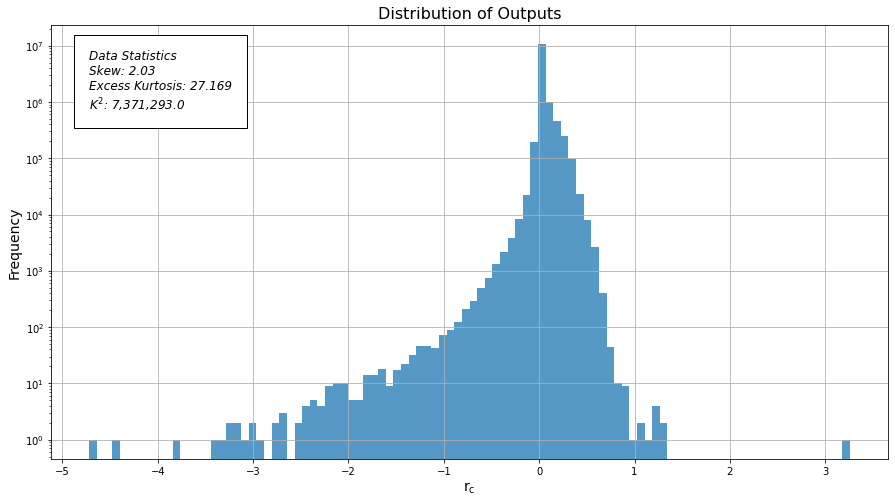

In [6]:
stat_orig = df.agg(['skew', 'kurtosis']).transpose()
start = stats.normaltest(df['r_c'].to_numpy())[0]

plt.rcParams['figure.figsize'] = [15, 8]

n, bins, patches = plt.hist(df['r_c'], 100, density=False, alpha=0.75)

xlim = np.min(bins)
ylim = np.max(n)

plt.text(xlim, ylim*0.07,
         'Data Statistics' + '\n' + 
         'Skew: ' + str(stat_orig['skew']['r_c'].round(decimals=2)) + '\n' + 
         'Excess Kurtosis: '+ str((stat_orig['kurtosis']['r_c'] - 3).round(decimals=3)) + '\n' +
         '$K^2$: ' + str("{:,}".format(start.round(decimals=0))),
         style='italic', fontsize=12,
         bbox={'facecolor': 'white', 'alpha': 1, 'pad': 15})

plt.xlabel('$\mathregular{r_c}$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Outputs', fontsize=16)
plt.yscale('log')
plt.grid(True)
plt.savefig(str('plots/ctq8*SM/pt_eta_phi/histograms/outputs.png'))
pp.savefig()

## Taking the Natural Log of the Data

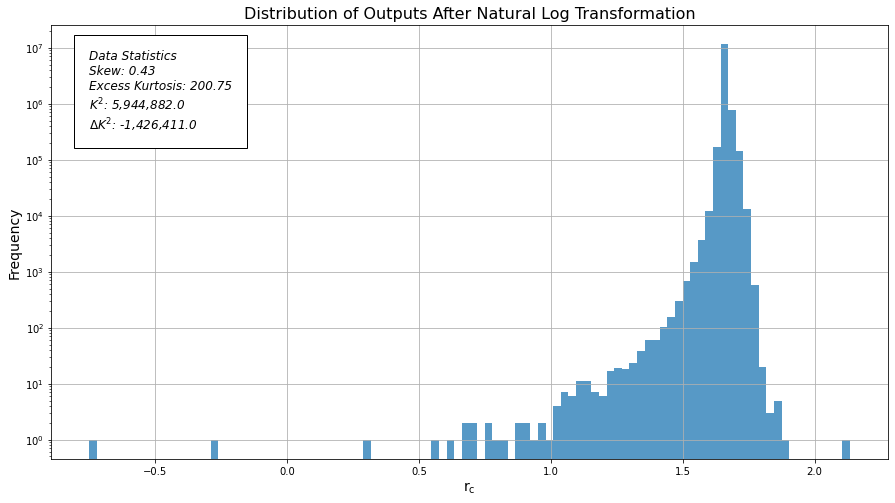

In [7]:
trans = df.copy(deep=True)
trans['r_c'] = np.log(trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy())*1.1)

plot(trans, 'Natural Log Transformation', 'log')

## Standard Normalization of the Data

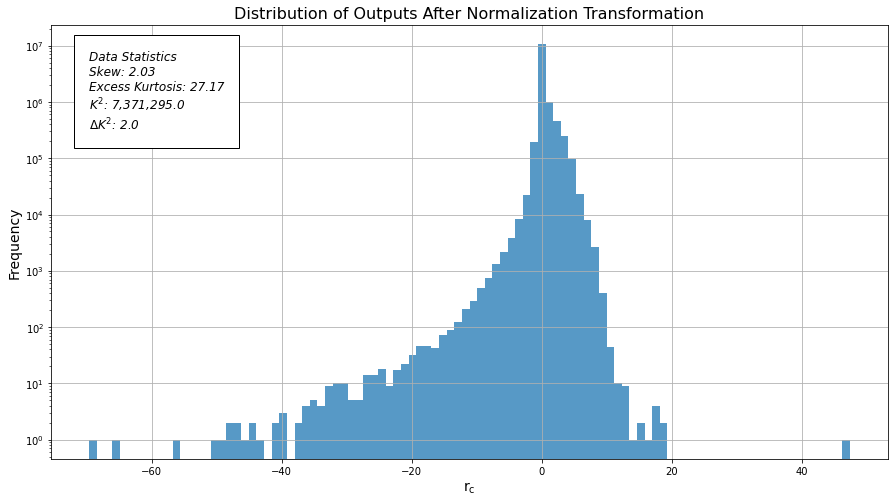

In [8]:
trans = df.copy(deep=True)
(trans, std, mean) = norm(df)

plot(trans, 'Normalization Transformation', 'norm')

## Pearson R Box-Cox Transformation

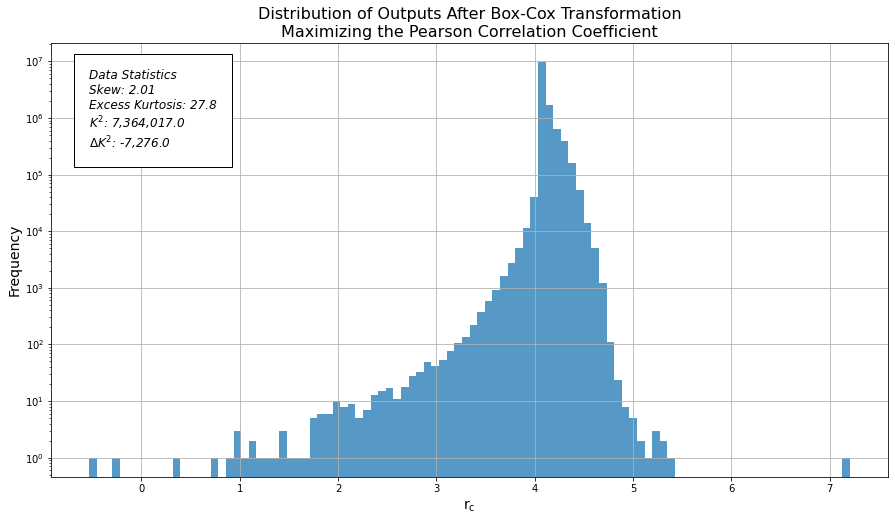

In [9]:
trans = df.copy(deep=True)
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.1)
pearsonr = stats.boxcox_normmax(trans['r_c'], method='pearsonr')
trans['r_c'] = stats.boxcox(trans['r_c'].to_numpy(), lmbda=pearsonr, alpha=None)

plot(trans, 'Box-Cox Transformation'  + '\n' +  
     'Maximizing the Pearson Correlation Coefficient', 'p_box_cox')

## Natural Log of Pearson R Box-Cox Transformation

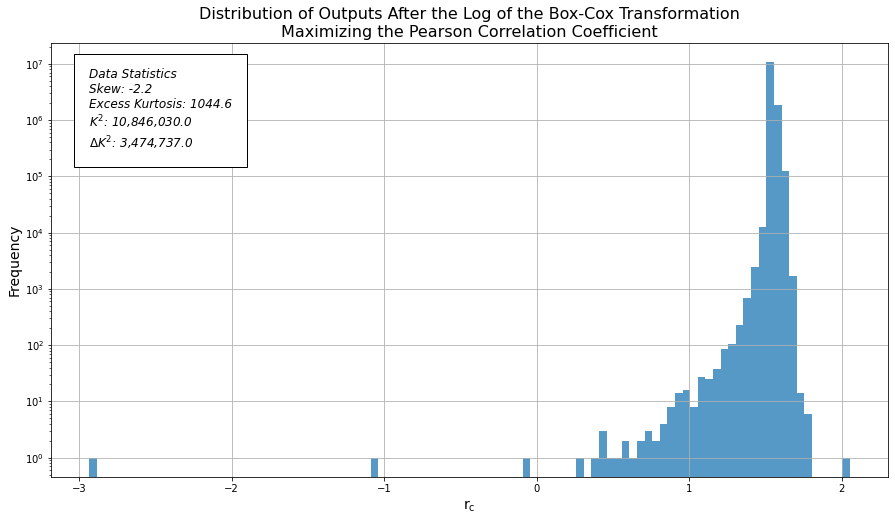

In [10]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.1)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'the Log of the Box-Cox Transformation' + '\n' +
     'Maximizing the Pearson Correlation Coefficient', 'log_p_box_cox')

## MLE Box-Cox Transformation

In [11]:
trans = df.copy(deep=True)
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
mle = stats.boxcox_normmax(trans['r_c'], method='mle')
trans['r_c'] = stats.boxcox(trans['r_c'].to_numpy(), lmbda=mle, alpha=None)

#plot(trans, 'Distribution of Outputs After Box-Cox Transformation' + '\n' + 
#     'Minimizing the Log-Likelihood', 'mle_box_cox')

## Natural Log of MLE Box-Cox Transformation

In [12]:
trans['r_c'] = np.log(trans['r_c'].to_numpy())

#plot(trans, 'Distribution of Outputs After the Log of the Box-Cox Transformation' + '\n' + 
#     'Minimizing the Log-Likelihood', 'log_mle_box_cox')

/srv/ipykernel_168/2017894093.py:1: RuntimeWarning: invalid value encountered in log
  trans['r_c'] = np.log(trans['r_c'].to_numpy())


## Pearson R Yeo-Johnson Transformation

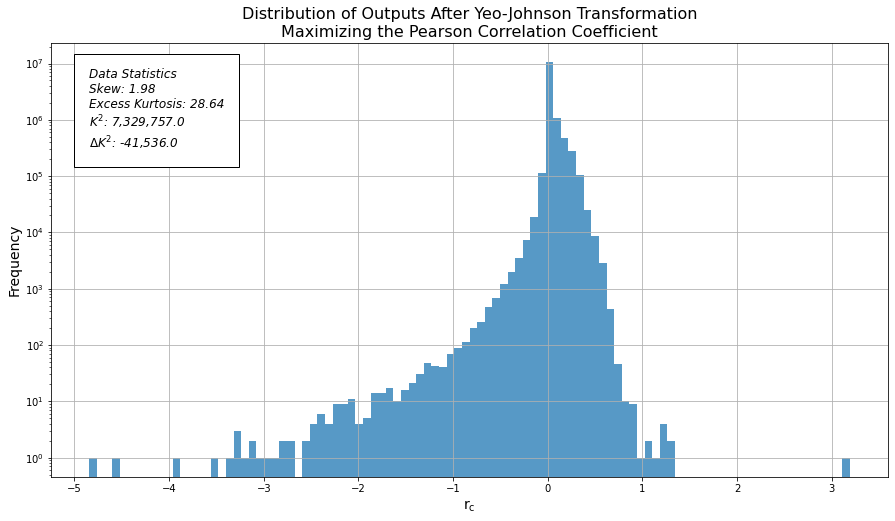

In [13]:
trans = df.copy(deep=True)
trans['r_c'] = stats.yeojohnson(trans['r_c'].to_numpy(), lmbda=pearsonr)

plot(trans, 'Yeo-Johnson Transformation' + '\n' +
     'Maximizing the Pearson Correlation Coefficient', 'p_yeo')

## Natural Log of  Yeo-Johnson Transformation

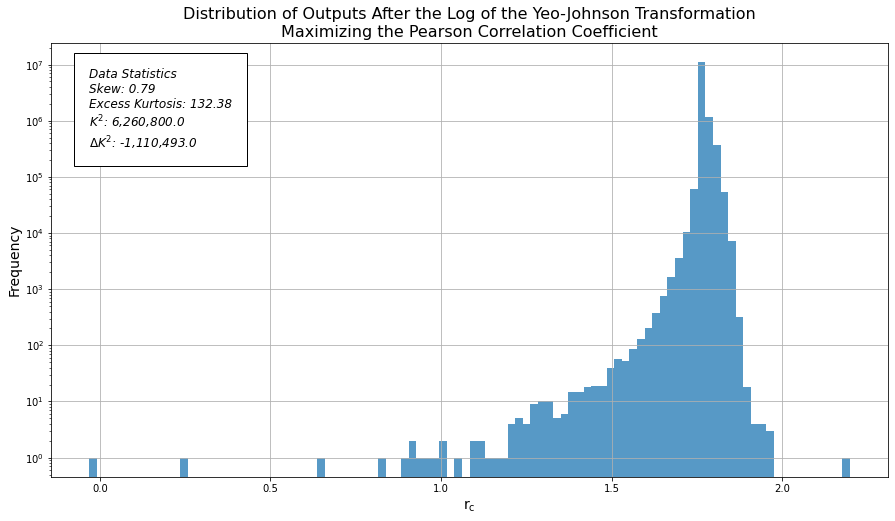

In [14]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'the Log of the Yeo-Johnson Transformation' + '\n' +
     'Maximizing the Pearson Correlation Coefficient', 'log_p_yeo')

## MLE Yeo-Johnson Transformation

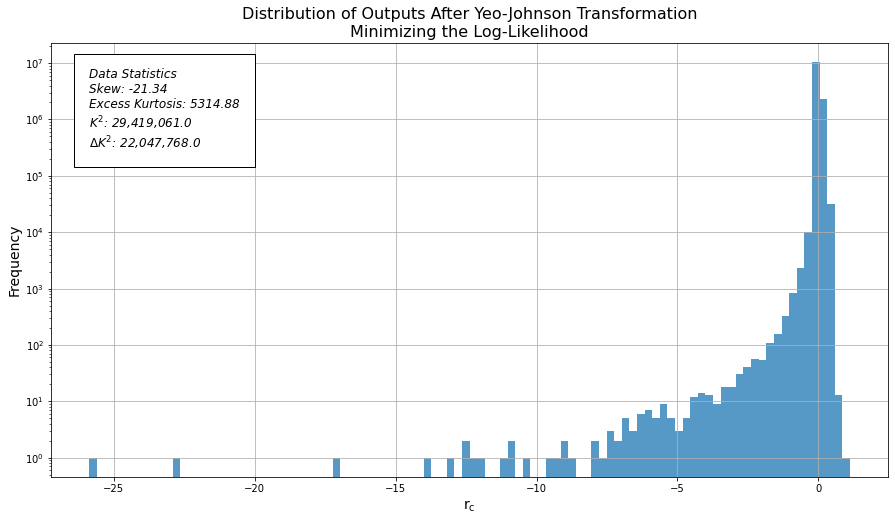

In [15]:
trans = df.copy(deep=True)
trans['r_c'] = stats.yeojohnson(trans['r_c'].to_numpy(), lmbda=mle)

plot(trans, 'Yeo-Johnson Transformation' + '\n' +
     'Minimizing the Log-Likelihood', 'mle_yeo')

## Natural Log of MLE Yeo-Johnson Transformation

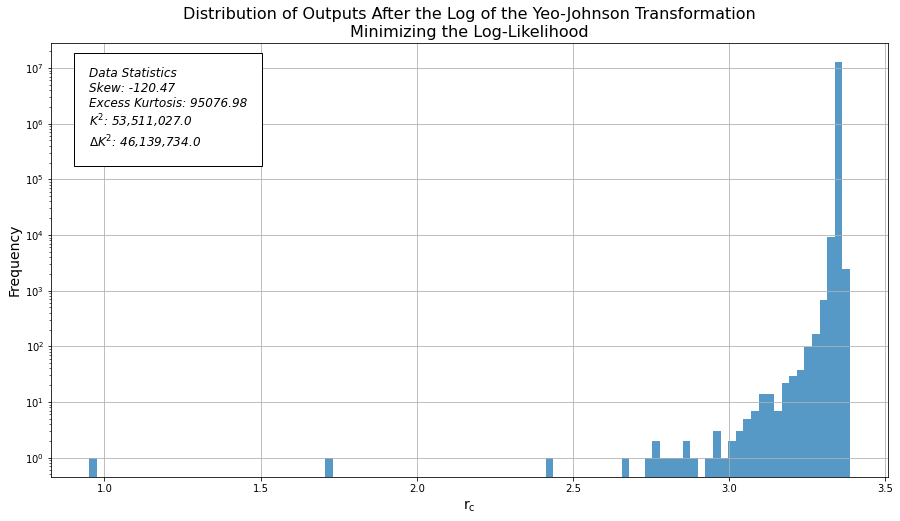

In [16]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.1)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'the Log of the Yeo-Johnson Transformation' + '\n' +
     'Minimizing the Log-Likelihood', 'log_mle_yeo')

## Normal Quantile Transformed

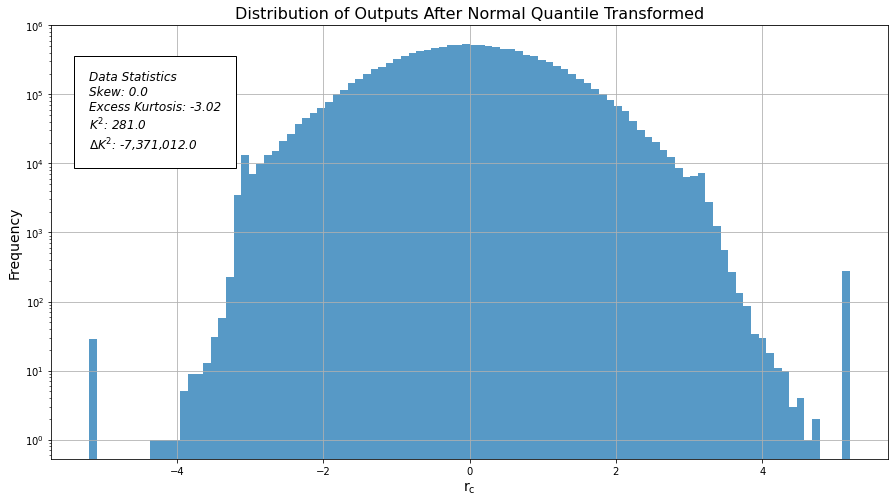

In [17]:
trans = df.copy(deep=True)
trans['r_c'] = quantile_transform(trans['r_c'].to_numpy().reshape(-1, 1), output_distribution='normal', copy=True)

plot(trans, 'Normal Quantile Transformed', 'norm_quantile')

# Filtering the Data

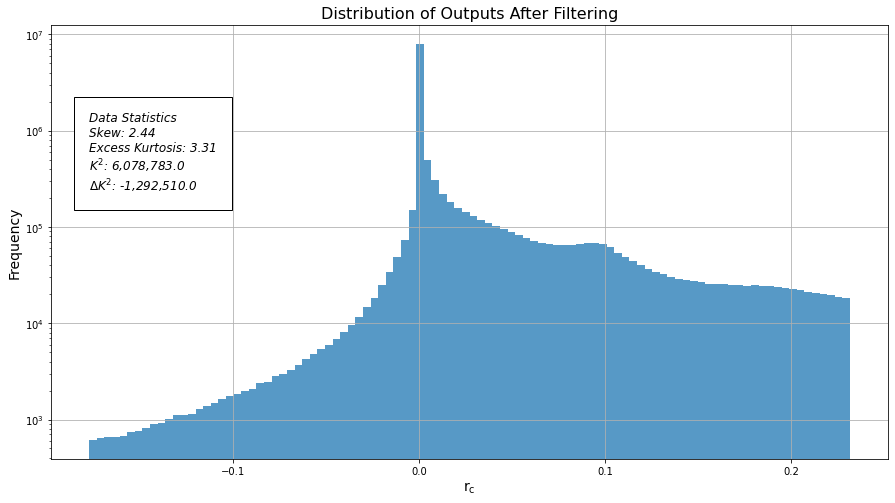

In [18]:
df = df[(df['r_c'] >= (df.mean()['r_c'] - 3*df.std()['r_c'])) & 
         (df['r_c'] <= (df.mean()['r_c'] + 3*df.std()['r_c']))]

plot(df, 'Filtering', 'filt')

## Taking the Natural Log of the Data

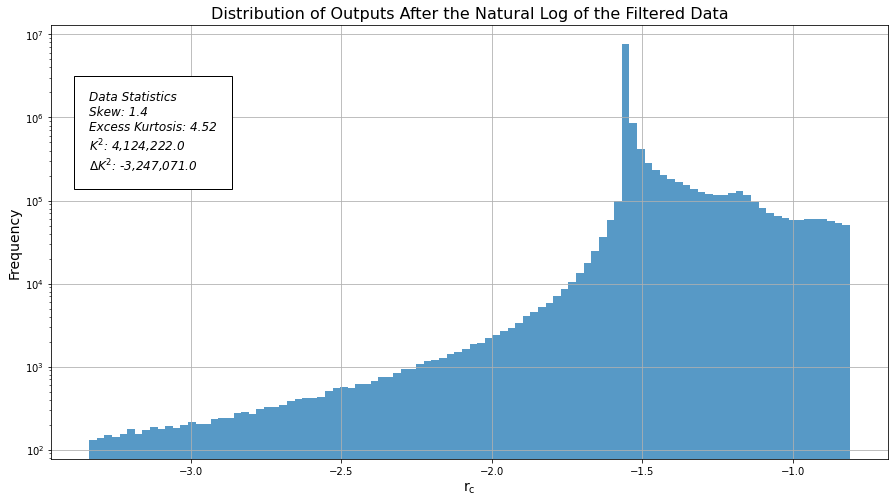

In [19]:
trans = df.copy(deep=True)
trans['r_c'] = np.log(trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy())*1.2)

plot(trans, 'the Natural Log of the Filtered Data', 'log_filt')

## Standard Normalization of the Data

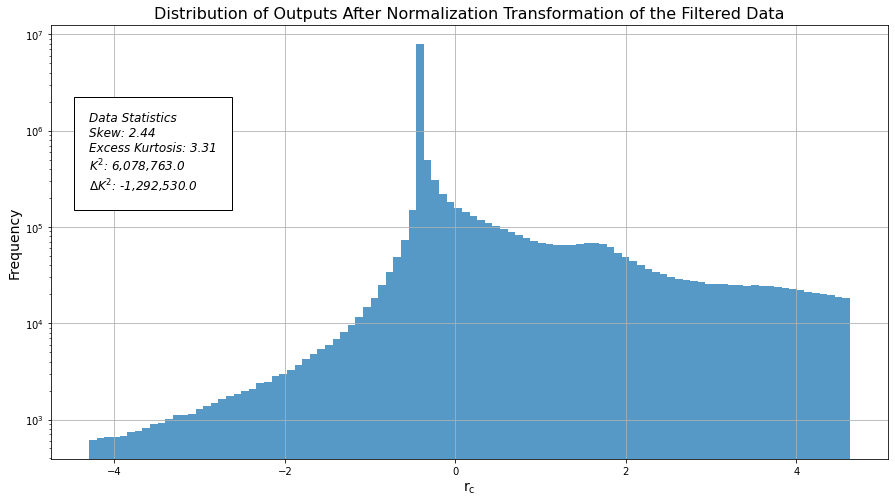

In [20]:
trans = df.copy(deep=True)
(trans, std, mean) = norm(df)

plot(trans, 'Normalization Transformation of the Filtered Data', 'norm_filt')

## Pearson R Box-Cox Transformation

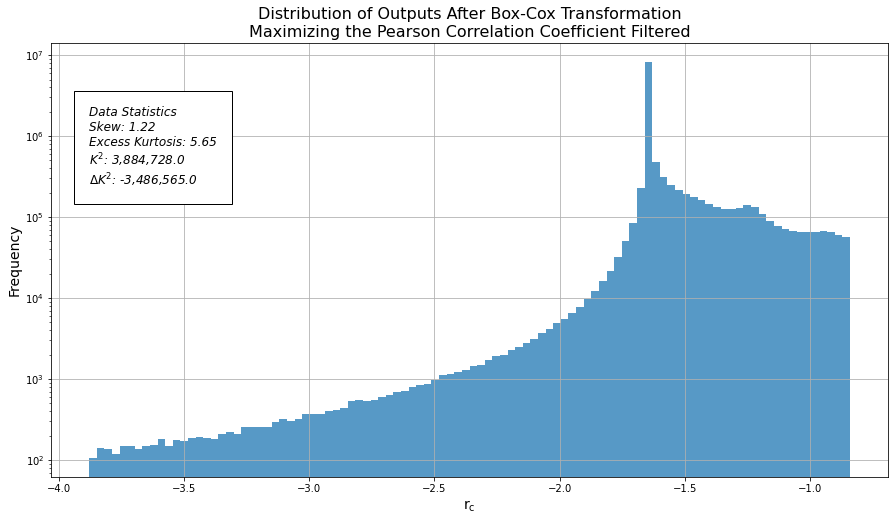

In [21]:
trans = df.copy(deep=True)
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
pearsonr = stats.boxcox_normmax(trans['r_c'], method='pearsonr')
trans['r_c'] = stats.boxcox(trans['r_c'].to_numpy(), lmbda=pearsonr, alpha=None)

plot(trans,  'Box-Cox Transformation' + '\n' + 
          'Maximizing the Pearson Correlation Coefficient Filtered', 'p_box_cox_filt')

## Natural Log of Pearson R Box-Cox Transformation

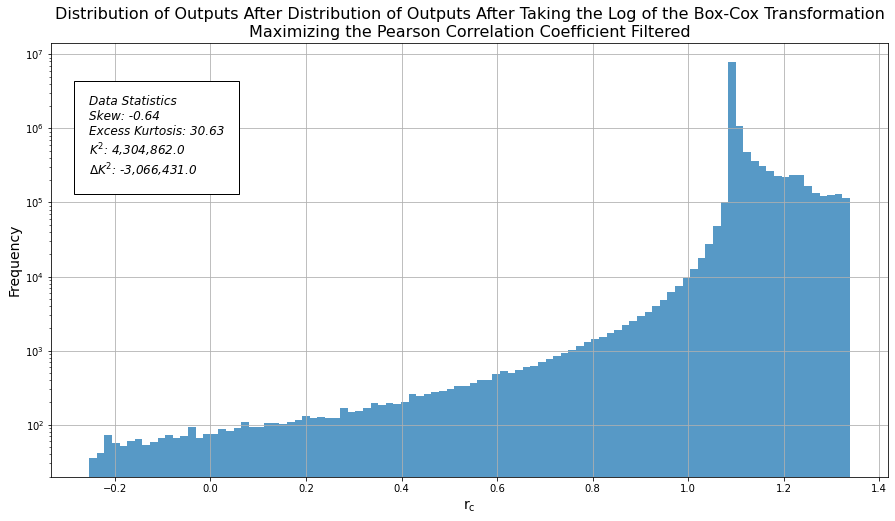

In [22]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'Distribution of Outputs After Taking the Log of the Box-Cox Transformation' + '\n' +
          'Maximizing the Pearson Correlation Coefficient Filtered', 'log_p_box_cox_filt')

## Pearson R Box-Cox Transformation

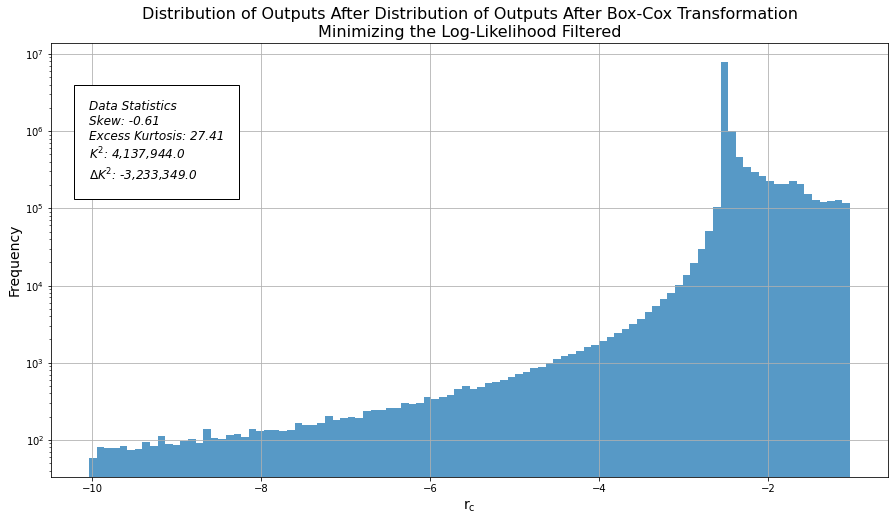

In [23]:
trans = df.copy(deep=True)
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
mle = stats.boxcox_normmax(trans['r_c'], method='mle')
trans['r_c'] = stats.boxcox(trans['r_c'].to_numpy(), lmbda=mle, alpha=None)

plot(trans, 'Distribution of Outputs After Box-Cox Transformation' + '\n' +  
          'Minimizing the Log-Likelihood Filtered', 'mle_box_cox_filt')

## Log Pearson R Box-Cox Transformation

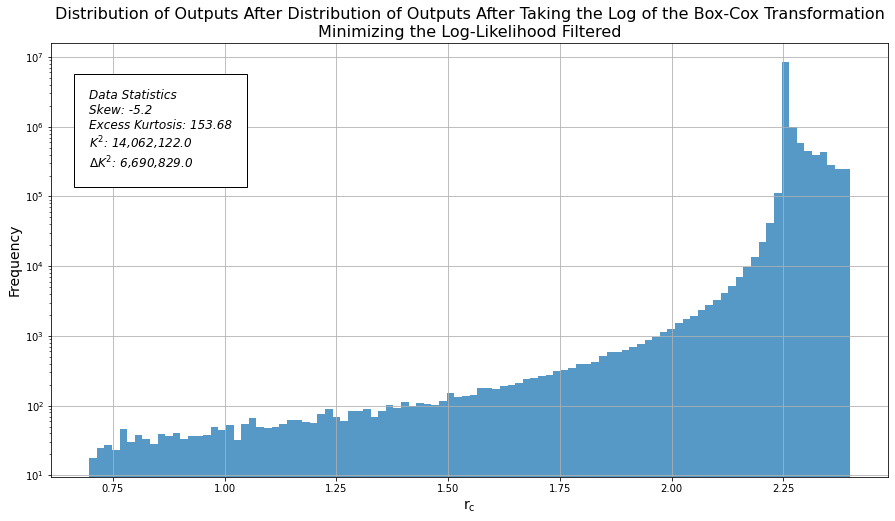

In [24]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'Distribution of Outputs After Taking the Log of the Box-Cox Transformation' + '\n' + 
          'Minimizing the Log-Likelihood Filtered', 'log_mle_box_cox_filt')

## Pearson R Yeo-Johnson Transformation

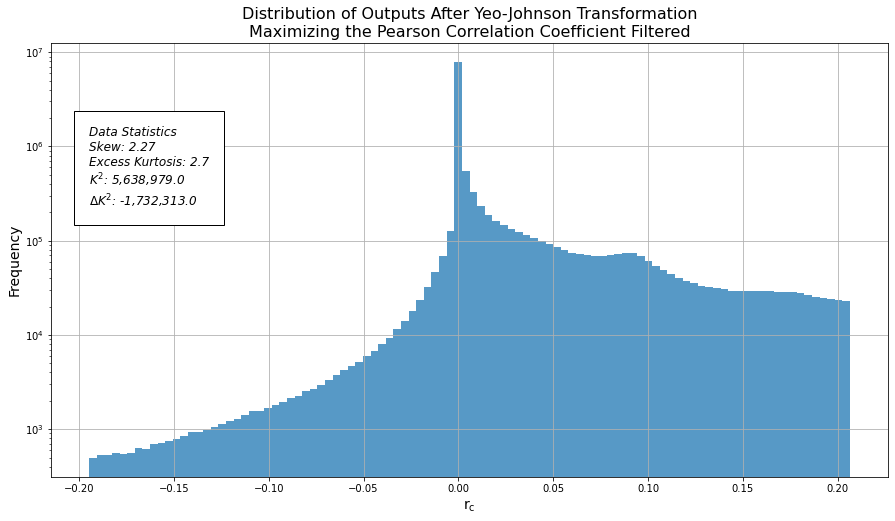

In [25]:
trans = df.copy(deep=True)
trans['r_c'] = stats.yeojohnson(trans['r_c'].to_numpy(), lmbda=pearsonr)

plot(trans, 'Yeo-Johnson Transformation' + '\n' +
     'Maximizing the Pearson Correlation Coefficient Filtered', 'p_yeo_filt')

## Natural Log of Pearson R Yeo-Johnson Transformation

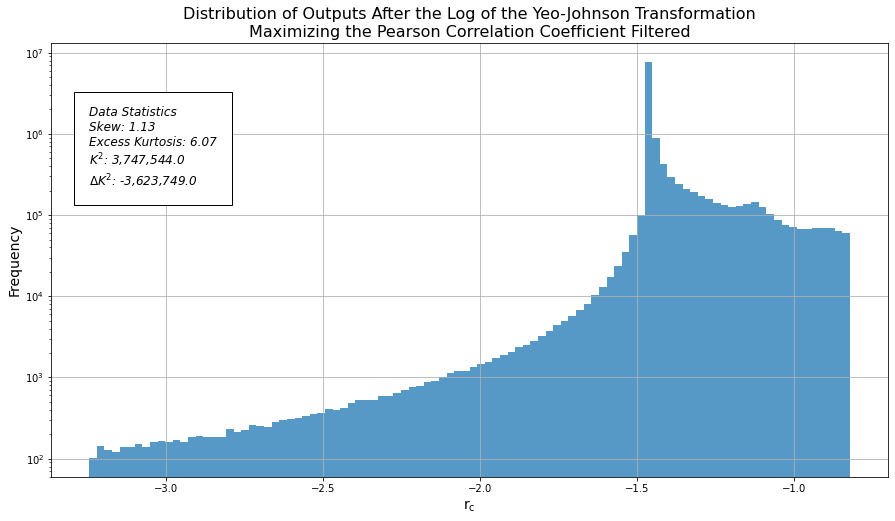

In [26]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'the Log of the Yeo-Johnson Transformation' + '\n' +
     'Maximizing the Pearson Correlation Coefficient Filtered', 'log_p_yeo_filt')

## MLE Yeo-Johnson Transformation

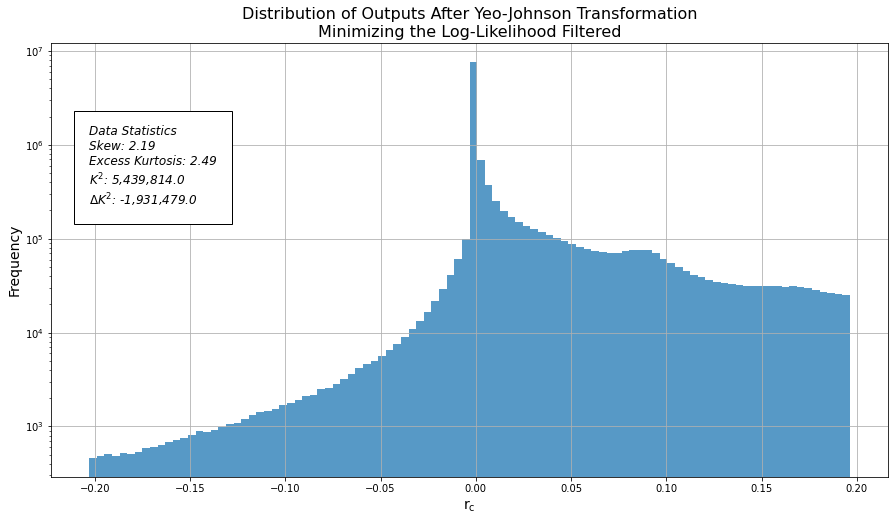

In [27]:
trans = df.copy(deep=True)
trans['r_c'] = stats.yeojohnson(trans['r_c'].to_numpy(), lmbda=mle)

plot(trans, 'Yeo-Johnson Transformation' + '\n' +
     'Minimizing the Log-Likelihood Filtered', 'mle_yeo_filt')

## Natural Log of MLE Yeo-Johnson Transformation

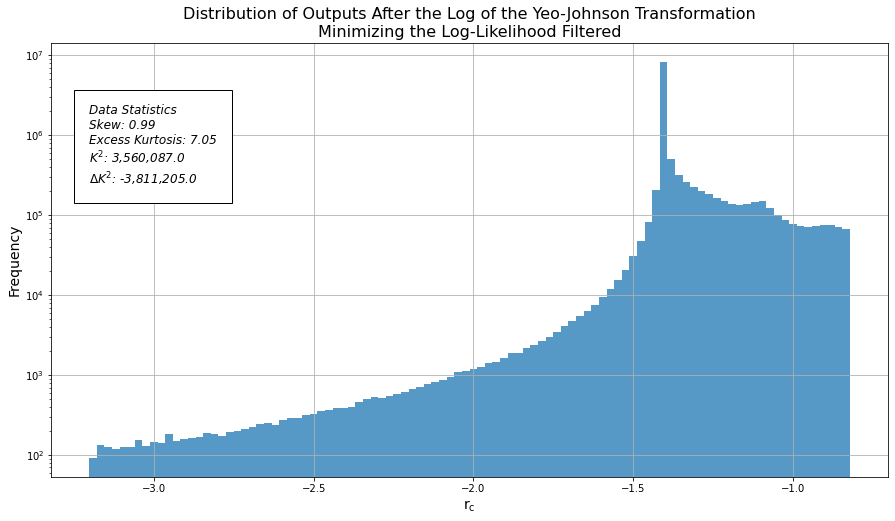

In [28]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'the Log of the Yeo-Johnson Transformation' + '\n' +
     'Minimizing the Log-Likelihood Filtered', 'log_mle_yeo_filt')

## Normal Quantile Transformed

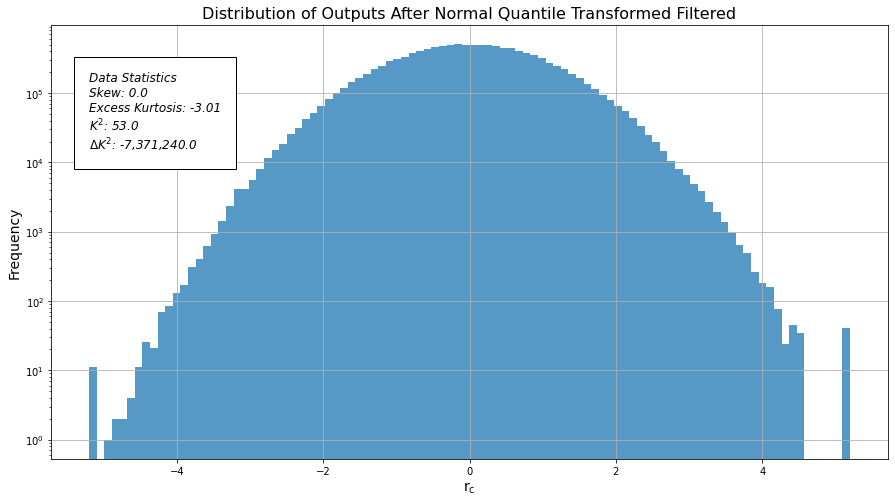

In [29]:
trans = df.copy(deep=True)
trans['r_c'] = quantile_transform(trans['r_c'].to_numpy().reshape(-1, 1), output_distribution='normal', copy=True)

plot(trans, 'Normal Quantile Transformed Filtered', 'norm_quantile_filt')

In [30]:
pp.close()

In [31]:
s_name

['Natural Log Transformation',
 'Normalization Transformation',
 'Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient',
 'the Log of the Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient',
 'Yeo-Johnson Transformation\nMaximizing the Pearson Correlation Coefficient',
 'the Log of the Yeo-Johnson Transformation\nMaximizing the Pearson Correlation Coefficient',
 'Yeo-Johnson Transformation\nMinimizing the Log-Likelihood',
 'the Log of the Yeo-Johnson Transformation\nMinimizing the Log-Likelihood',
 'Normal Quantile Transformed',
 'Filtering',
 'the Natural Log of the Filtered Data',
 'Normalization Transformation of the Filtered Data',
 'Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient Filtered',
 'Distribution of Outputs After Taking the Log of the Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient Filtered',
 'Distribution of Outputs After Box-Cox Transformation\nMinimizing the Log-Likelihood Filtered',
 

In [32]:
s_value

[5944882.009986526,
 7371294.808001704,
 7364017.252794459,
 10846030.157962997,
 7329757.055118658,
 6260799.883082005,
 29419061.009881623,
 53511026.960112594,
 280.68256702246896,
 6078782.518525629,
 4124221.693137376,
 6078763.027279498,
 3884727.5032294537,
 4304861.643552642,
 4137944.3007700783,
 14062121.728068028,
 5638979.39851803,
 3747543.9189193863,
 5439813.791026362,
 3560087.4275357933,
 52.90000474127673]

In [33]:
d = {'Test': s_name, 'K-Squared': s_value}
results = pd.DataFrame(s_value, columns=['K-Squared'], index=s_name)
results

,K-Squared
Natural Log Transformation,5.944882e+06
Normalization Transformation,7.371295e+06
Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient,7.364017e+06
the Log of the Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient,1.084603e+07
Yeo-Johnson Transformation\nMaximizing the Pearson Correlation Coefficient,7.329757e+06
the Log of the Yeo-Johnson Transformation\nMaximizing the Pearson Correlation Coefficient,6.260800e+06
Yeo-Johnson Transformation\nMinimizing the Log-Likelihood,2.941906e+07
the Log of the Yeo-Johnson Transformation\nMinimizing the Log-Likelihood,5.351103e+07
Normal Quantile Transformed,2.806826e+02
Filtering,6.078783e+06
